# Airbnb NYC 2019


In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 10

import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Exploration
Load data and perform first exploration

In [73]:
df_airbnb = pd.read_csv('./Data/AB_NYC_2019.csv')

In [4]:
df_airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
print('Number of entries: {} \nNumber of features: {}'.format(df_airbnb.shape[0], df_airbnb.shape[1]))

Number of entries: 48895 
Number of features: 16


A first look suggests that columns such as **id**, **name** and **host_name** can be discarded from the analysis. 

The column **name** could be used to incorporate some more features (keywords appearing in the name). This will be discarded on the first simple models.

In [74]:
# drop features id, host_id and host_name
df_airbnb.drop(['id', 'name', 'host_name'], axis=1, inplace=True)

Now we will look for missing data on the remaining features

In [75]:
df_airbnb.isnull().sum()

host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We have missing data for the following features:
* last_review --> comes from entries without any review
* reviews_per_month --> comes from entries without any review; we will replace it by 0

In [76]:
# replace NaN by 0 for column reviews per month
df_airbnb.reviews_per_month.fillna(0, inplace=True)

So far we have 13 columns, 12 of them corresponding to features and 1 corresponding to our target variable, price. 

First we will start by taking a look to the price to see its distribution and check there are no inconsistencies.

Then we will explore the features and their distributions and correlation among them. We can expect high correlation between:
* neighbourhood_group, neighbourhood, latitude and longitude
* number_of_reviews and reviews_per_month (can also be related with last_review)
* influence of host_id

### Exploration of price

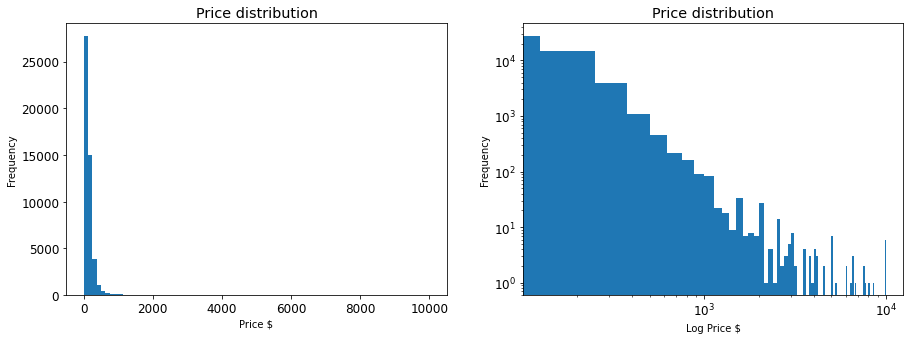

In [9]:
f, ax = plt.subplots(1, 2, figsize=(15,5))
df_airbnb['price'].plot(kind='hist', bins=80, title='Price distribution', ax=ax[0])
df_airbnb['price'].plot(kind='hist', bins=80,logx=True, logy=True, title='Price distribution', ax=ax[1])
ax[0].set_xlabel('Price $')
ax[1].set_xlabel('Log Price $')
plt.show()

In [77]:
print('Number of cases with price = $0: ',len(df_airbnb[df_airbnb.price == 0]))

Number of cases with price = $0:  11


Appartments with price \\$0 may correspond to an error or a fake offert, therefore we will drop them.

In [11]:
# drop cases with price 0
df_airbnb.drop(df_airbnb[df_airbnb.price < 10]. index, axis=0, inplace=True)

In [14]:
def print_pct_price(attribute, value):
    print('Appartments with {} over ${}: {:.2f}%'.\
          format(attribute, \
                 value, \
                 100 * len(df_airbnb[df_airbnb[attribute] > value])/len(df_airbnb)))

for p in [200, 300, 500, 1000]:
    print_pct_price('price', p)


Appartments with price over $200: 17.15%
Appartments with price over $300: 6.87%
Appartments with price over $500: 2.14%
Appartments with price over $1000: 0.49%


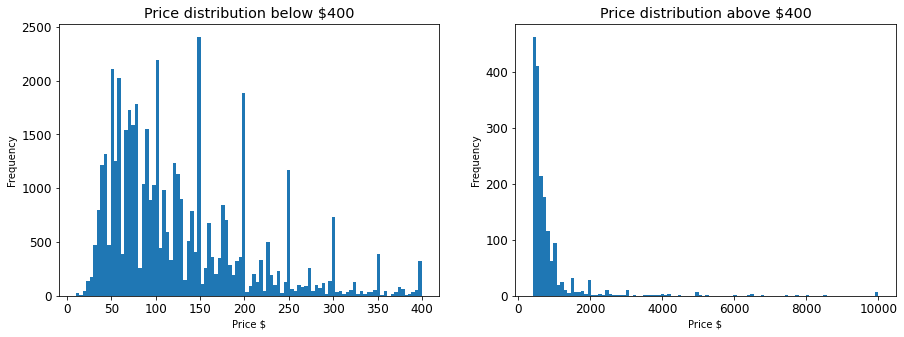

In [15]:
f, ax = plt.subplots(1, 2, figsize=(15,5))
price_max = 400
df_airbnb[df_airbnb['price'] <= price_max].price.plot(kind='hist', bins=100,\
                                                title='Price distribution below ${}'.format(price_max), ax=ax[0])
df_airbnb[df_airbnb['price'] > price_max].price.plot(kind='hist', bins=100, \
                                                     title='Price distribution above ${}'.format(price_max), ax=ax[1])
ax[0].set_xlabel('Price $')
ax[1].set_xlabel('Price $')
plt.show()


Insights: 
* Mean price is \\$153 and median price is \\$106. This reflects large outliers that increase the mean price.
* Min price is \\$0 while max price is \\$10k. We will drop the cases with price = \\$0 since they may correspond to errors.
* Around 95% of the appartments have a price lower than \\$300. From these, a good amount concentrate in a range lower than \\$100. We can also observe some peaks around round prices (100, 150, etc.)
* Appartments over \\$1k represent less than 0.5\% of the cases.

### Exploration of features

The features **neighbourhood** is left out of the plot due to the large number of possible values. The feature **last_review** is left out of the plot since we cannot relate it to the date when the prices were retrieved.

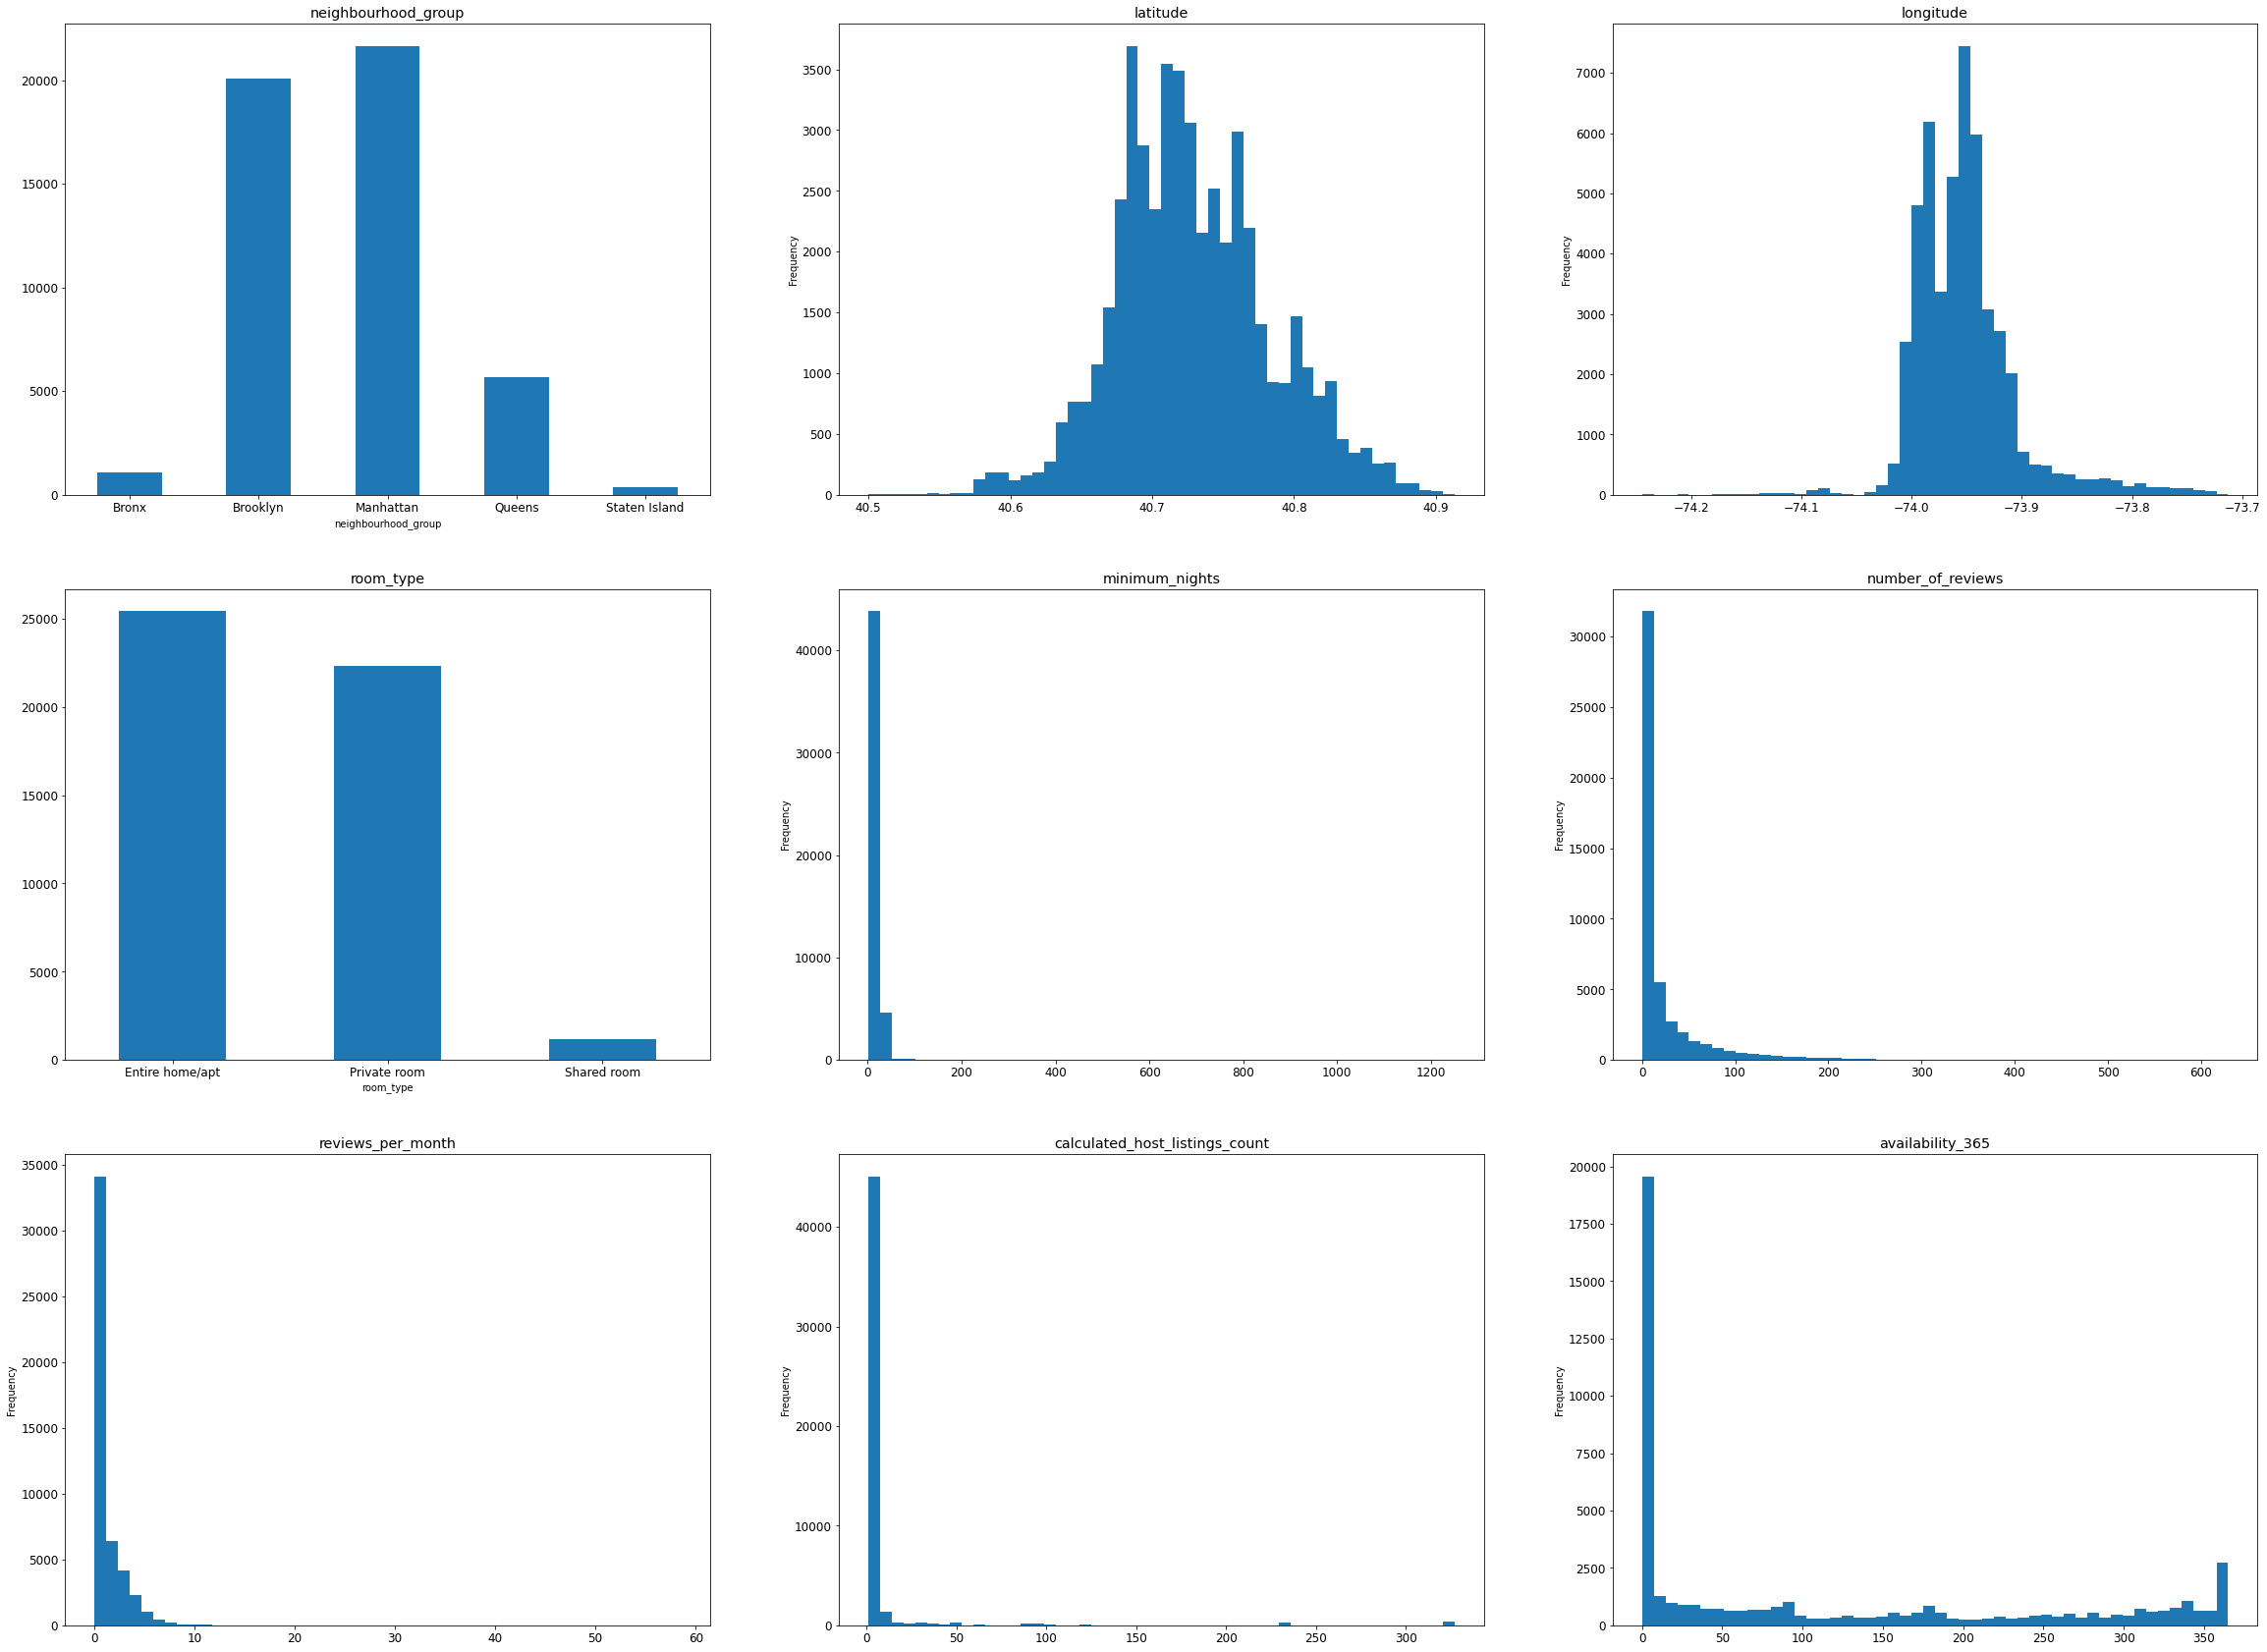

In [16]:
f, ax = plt.subplots(3,3, figsize=(40,30))
ax = ax.flatten()
for idx, col in enumerate(df_airbnb.drop(['host_id','neighbourhood', 'last_review', 'price'], axis=1).columns):
    if df_airbnb[col].dtype == object:
        df_airbnb.groupby(col).count().iloc[:,1].plot(kind='bar', ax=ax[idx], title=col)
        ax[idx].tick_params(axis='x', rotation=0)
    else:
        df_airbnb[col].plot(kind='hist', bins=50, ax=ax[idx], title=col)

Insights: 
* Neighbourhood: Brooklyn and Manhattan are the most represented ones.
* Most locations offered are entire appartments or private rooms. Shared rooms are very rare.
* Number of reviews and reviews per month seem to follow a Poisson distribution.
* Minimum nights and host listing count may offer more insights when taking logarithm of the values. 
* Availability is highly concentrated aroud 1 and then there is a great decrease for the rest of values.

#### Analysis per neighbourhood

In [17]:
df_airbnb.groupby('neighbourhood_group').agg({'neighbourhood':['count','nunique'], 
                                              'price':['min', 'mean', 'median', 'max'],
                                             'number_of_reviews':['min', 'mean', 'median', 'max']})

neighbourhood         price                            \
                            count nunique   min        mean median    max   
neighbourhood_group                                                         
Bronx                        1090      48    10   87.577064     65   2500   
Brooklyn                    20095      47    10  124.438915     90  10000   
Manhattan                   21660      32    10  196.884903    150  10000   
Queens                       5666      51    10   99.517649     75  10000   
Staten Island                 373      43    13  114.812332     75   5000   

                    number_of_reviews                         
                                  min       mean median  max  
neighbourhood_group                                           
Bronx                               0  25.977982      9  321  
Brooklyn                            0  24.197661      6  488  
Manhattan                           0  20.986565      4  607  
Queens                              0  27.700318      7  629  
Staten Island                       0  30.941019     12  333

If we analyse by neighbourhood, we can highlight:
* Manhattan is the one grouping less neighbourhoods with around 60% of the neighbourhoods that Queens groups (which is the one with the largest value).
* In terms of price, they all have almost the same minimum price. Nevertheless, Manhattan shows a median price that is almost 3 times the median of the lowest price (Bronx). The maximum price at Bronx is 25% of the maximum at Manhattan, Brooklyn and Staten Island. 
* In terms of number of reviews, the median is much lower than the mean in all cases, showing the presence of large sporadic numbers and a great amount of low values.

In [18]:
def plot_price_dist(col_name):
    f, ax = plt.subplots(1,2, figsize=(20,5))
    ax = ax.flatten()

    sns.violinplot(data=df_airbnb[df_airbnb.price < 400], x=col_name, y='price', ax=ax[0])
    sns.violinplot(data=df_airbnb, x=col_name, y='price', ax=ax[1])
    ax[0].set_title('Price (up to $350) vs {}'.format(col_name))
    ax[1].set_title('Price vs {}'.format(col_name))
    plt.show()

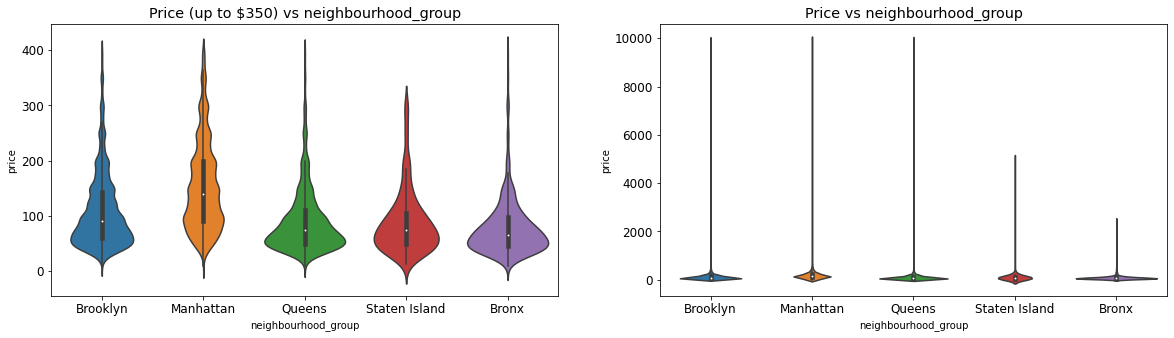

In [19]:
plot_price_dist('neighbourhood_group')

#### Analysis type of room

In [20]:
df_airbnb.groupby('room_type').agg({'price':['min', 'mean', 'median', 'max'],
                                    'number_of_reviews':['min', 'mean', 'median', 'max']})

price                           number_of_reviews             \
                  min        mean median    max               min       mean   
room_type                                                                      
Entire home/apt    10  211.810918    160  10000                 0  22.844098   
Private room       10   89.809131     70  10000                 0  24.104082   
Shared room        10   70.248705     45   1800                 0  16.622625   

                             
                median  max  
room_type                    
Entire home/apt      5  488  
Private room         5  629  
Shared room          4  454

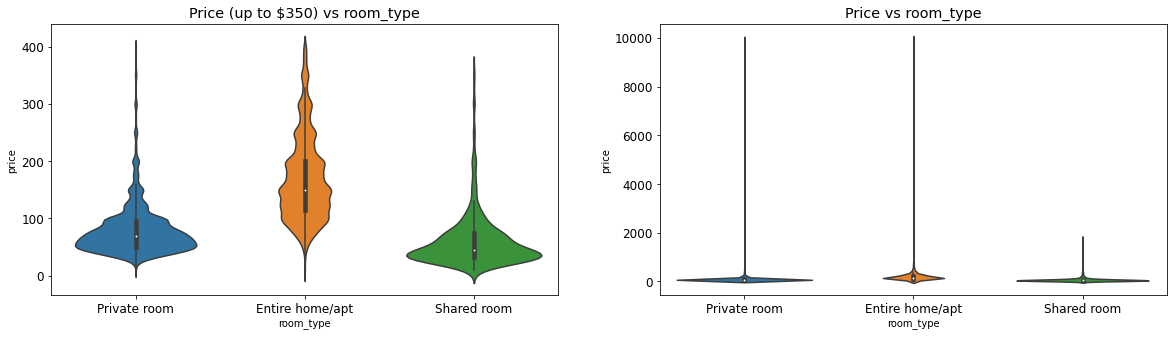

In [21]:
plot_price_dist('room_type')

From the type of room, we can highlight:
* Private and Share rooms have a similar mean price but private rooms can increase to much higher prices ( \\$10k vs \\$1.8k) 

#### Analysis reviews
The columns **last review** does not offer us much data since this value is static and we cannot relate it to the current date (the data has not been updated and we don't know the day when it was generated). Therefore, we will not consider it. 

We expect high correlation between **number of reviews** and **reviews per month**

In [78]:
df_airbnb.drop(['last_review'], axis=1, inplace=True)
df_airbnb.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


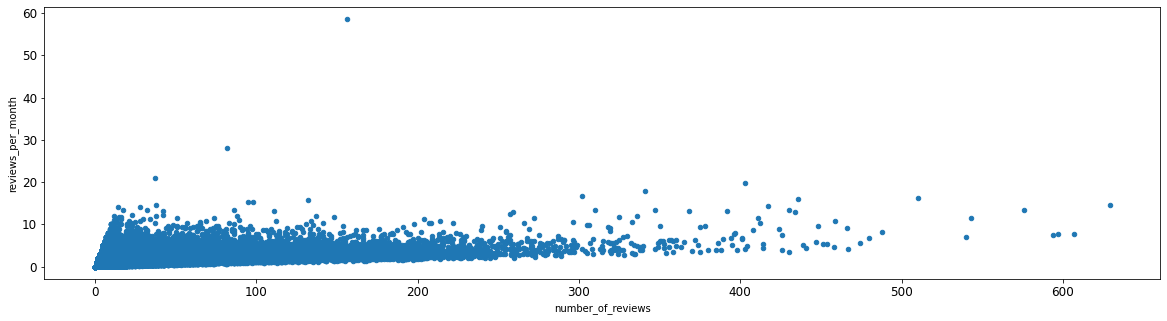

In [23]:
f, ax = plt.subplots(figsize=(20,5))
df_airbnb.plot(kind='scatter', x='number_of_reviews', y='reviews_per_month', ax=ax)
plt.show()

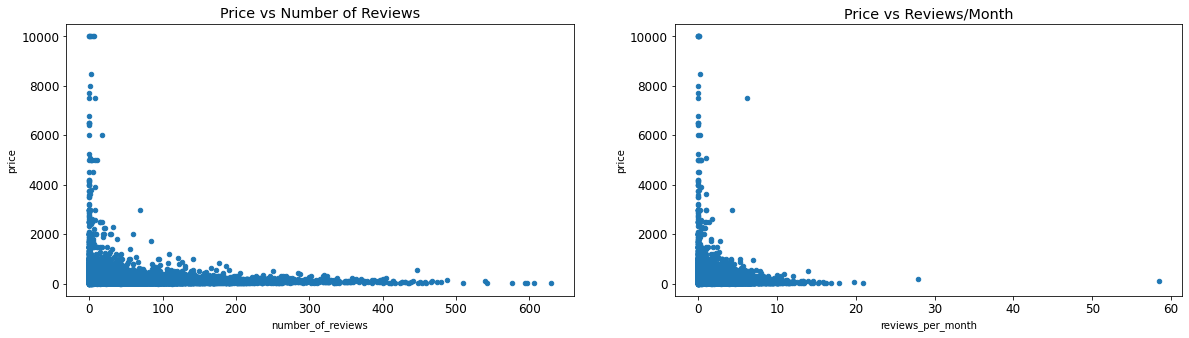

In [24]:
f, ax = plt.subplots(1,2,figsize=(20,5))
df_airbnb.plot(kind='scatter', x='number_of_reviews', y='price', \
               ax=ax[0], title='Price vs Number of Reviews')
df_airbnb.plot(kind='scatter', x='reviews_per_month', y='price', \
               ax=ax[1], title='Price vs Reviews/Month')

plt.show()

Insights from reviews:
* Number of reviews and reviews per month are correlated although less than expected. The relation is bounded. 
* The relation with price shows an exponential decay.

#### Correlation between features and encoding of categorical variables

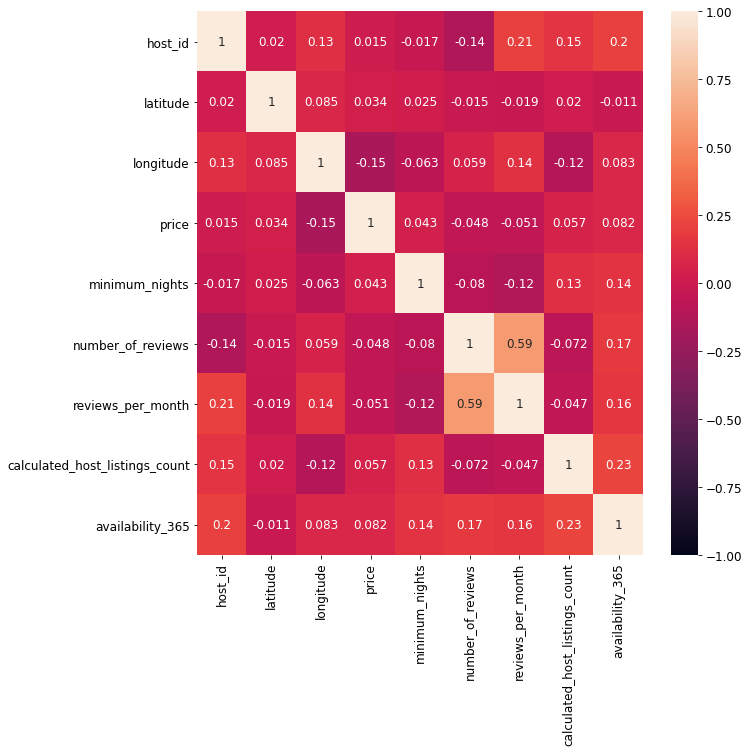

In [79]:
features = df_airbnb.drop(['neighbourhood_group', 'neighbourhood', 'room_type'], axis=1).columns
corr = np.corrcoef(df_airbnb[features].transpose()).round(decimals=3)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=ax, \
            xticklabels=features, yticklabels=features)
plt.show()

**Insights from the plot:**

- Longitude (related to neighbourhood) is the most correlated feature
- Host_id is the least correlated feature. Although we could have first though that the presence of host with large amount of facilities could help to predict the price for those appartments sharing owner, its contribution is very small to the overall set of observations. 

In general the numerical features explored doesn't seem to be highly correlated with the target variable.

In [27]:
# drop neighbourhood prioritizing neighbourhood group
df_airbnb.drop(['neighbourhood'], axis=1, inplace=True)

# transform categorical variables to 1-hot encoding
df_airbnb_encoded = pd.get_dummies(df_airbnb)

In [29]:
df_airbnb_encoded.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,ln_price,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2787,40.64749,-73.97237,149,1,9,0.21,6,365,5.010635,0,1,0,0,0,0,1,0
1,2845,40.75362,-73.98377,225,1,45,0.38,2,355,5.420535,0,0,1,0,0,1,0,0
2,4632,40.80902,-73.94190,150,3,0,0.00,1,365,5.017280,0,0,1,0,0,0,1,0
3,4869,40.68514,-73.95976,89,1,270,4.64,1,194,4.499810,0,1,0,0,0,1,0,0
4,7192,40.79851,-73.94399,80,10,9,0.10,1,0,4.394449,0,0,1,0,0,1,0,0


## Price Prediction:

* Create train and test set
* Standardize features
* For different models:
    - Train, tune hyperparameters, evaluate performance


In [30]:
price_outliers = 350

In [57]:
df_outliers = df_airbnb_encoded.drop(df_airbnb_encoded[df_airbnb_encoded['price'] > price_outliers].index, axis=0)
X, y = df_outliers.drop(['price'], axis=1), df_outliers.price

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# scale features
scale = StandardScaler().fit(X_train)
X_train_transformed = scale.transform(X_train.values)
X_test_transformed = scale.transform(X_test.values)

# scale price
scale_price = StandardScaler().fit(y_train.values.reshape(-1,1))
y_train_transformed = scale_price.transform(y_train.values.reshape(-1,1))
y_test_transformed = scale_price.transform(y_test.values.reshape(-1,1))


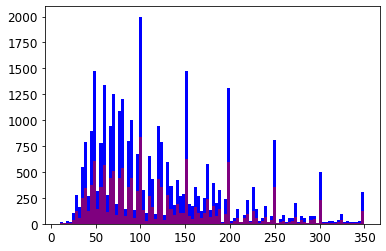

In [58]:
plt.hist(y_train, bins=100, color='b', label='train')
plt.hist(y_test, bins=100, color='r', alpha=0.5, label='test')
plt.title('Price distribution after normalization')
plt.legend()
plt.show()

## Define metrics and functions

In [33]:
def get_score(y_pred, y_true):
    print('RMSE: {:.4f}'.format(mean_squared_error(y_true, y_pred, squared=False)))
    print('MAE : {:.4f}'.format(mean_absolute_error(y_true, y_pred)))
    print('R2  : {:.4f}'.format(r2_score(y_true, y_pred)))


In [34]:
def fit_predict_cv(model, X_train, y_train, params, cv=5):
    grid = GridSearchCV(estimator=model, param_grid=params, cv=cv)
    grid.fit(X_train, y_train)
    return grid

In [35]:
def fit_predict_best(model, X_train, y_train, X_test, y_test):
    t = time.time()
    model.fit(X_train, y_train)
    print('Training time {:.2f}s'.format(time.time() - t))

    t = time.time()
    y_pred = model.predict(X_test)
    print('Inference time {:.2f}s'.format(time.time() - t))

    get_score(y_pred, y_test)
    return y_pred

#### Model 1. Ridge Regression

- Parameters to fit: regularization term
- Pros: Simple, fast to train
- Cons: Very limited modeling capacity

In [59]:
params1 = {'alpha': np.logspace(-3, 3, 20)}
model1 = Ridge()

# hyperparameter tunning through cross-validation
grid1 = fit_predict_cv(model1, X_train_transformed, y_train_transformed, params1, cv=5)
print('Best pameters: ', grid1.best_params_)

# define best model
model1_best = Ridge(alpha=grid1.best_params_['alpha'])
# train and predict 
y_pred1 = fit_predict_best(model1_best, X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed)

Best pameters:  {'alpha': 112.88378916846884}
Training time 0.00s
Inference time 0.00s
RMSE: 0.7242
MAE : 0.5287
R2  : 0.4702


#### Model 2. Elastic Net

- Parameters to fit: regularization term, l1 ratio (regularization as l2 or l1 norm penalty)
- Pros: Simple, fast to train
- Cons: Very limited modeling capacity

In [60]:
params2 = {'alpha':np.logspace(-2, 2, 10), 'l1_ratio':np.linspace(1e-2, 1, 10)}

model2 = ElasticNet(max_iter=100)
grid2 = fit_predict_cv(model2, X_train_transformed, y_train_transformed, params2, cv=5)
print('Best pameters: ', grid2.best_params_)

model2_best = ElasticNet(alpha=grid2.best_params_['alpha'], \
                        l1_ratio=grid2.best_params_['l1_ratio'])

y_pred2 = fit_predict_best(model2_best, X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed)

Best pameters:  {'alpha': 0.01, 'l1_ratio': 0.01}
Training time 0.05s
Inference time 0.00s
RMSE: 0.7242
MAE : 0.5287
R2  : 0.4701


#### Model 3. Random Forest Regressor

- Parameters to fit: maximum depth of decision trees, number of trees. Other parameters that could be explored are min_number_splits or max_features (max. number of features selected when fitting each tree; default all)
- Pros: Ensamble method, reduces overfitting. Large modeling flexibility
- Cons: Slower to train

**Random Forest default parameters**

In [71]:
y_pred3_default = fit_predict_best(RandomForestRegressor(), X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed)

Training time 14.08s
Inference time 0.37s
RMSE: 0.6545
MAE : 0.4596
R2  : 0.5672


**Random Forest tunned hyperparameters**

In [61]:
params3 = {'max_depth': range(5,12,2), 'n_estimators': (50, 100, 500)}

model3 = RandomForestRegressor()
grid3 = fit_predict_cv(model3, X_train_transformed, y_train_transformed, params3, cv=5)

print('Best pameters: ', grid3.best_params_)
model3_best = RandomForestRegressor(max_depth=grid3.best_params_["max_depth"], \
                                    n_estimators=grid3.best_params_["n_estimators"],
                                    random_state=False, verbose=False)

y_pred3 = fit_predict_best(model3_best, X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed)

Best pameters:  {'max_depth': 11, 'n_estimators': 500}
Training time 38.47s
Inference time 0.48s
RMSE: 0.6495
MAE : 0.4570
R2  : 0.5737


#### Model 4. MLP

- Parameters to fit: number of hidden layers, size of hidden layers, regularization parameter (l2-norm), learning rate (possible usage of optimizers), maximum number of iterations. Activation function of hidden layers is set to ReLU given the nature of the problem.
- Pros: Large modeling flexibility
- Cons: Slower to train, difficult interpretability

**MLP default hyperparameters**

In [70]:
y_pred4_default = fit_predict_best(MLPRegressor(), X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed)

Training time 24.93s
Inference time 0.03s
RMSE: 0.6690
MAE : 0.4805
R2  : 0.5479


**MLP tunned hyperparameters**

In [62]:
#(10,10,10) -> 3 hidden layers of size 10
# default solver -> Adam
params4 = [{  
    'hidden_layer_sizes': [(100,), (50,50), (50,50,50)], 
    'activation': ['relu'], 
    'alpha':[1e-2], 
    'learning_rate_init':[1e-3, 1e-4], 
    'max_iter':[100],
    'validation_fraction':[0.2],
    'solver':['sgd']
}]

 

model4 = MLPRegressor(verbose=False)
grid4 = fit_predict_cv(model4, X_train_transformed, y_train_transformed, params4, cv=5)
print('Best pameters: ', grid4.best_params_)

model4_best = MLPRegressor(
    hidden_layer_sizes=grid4.best_params_['hidden_layer_sizes'],\
    activation='relu', alpha=grid4.best_params_['alpha'],\
    learning_rate_init=grid4.best_params_['learning_rate_init'],\
    max_iter=grid4.best_params_['max_iter'],
    solver='sgd')

y_pred4 = fit_predict_best(model4_best, X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed)

Best pameters:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'sgd', 'validation_fraction': 0.2}
Training time 22.21s
Inference time 0.04s
RMSE: 0.6714
MAE : 0.4781
R2  : 0.5445


**Comment results:**

4 different models have been trained to predict prices of Airbnb facilities. Among them, the best results are achieved with **Model 3: Random Forest**. This model achieves both lower RMSE and MAE and higher $R^2$. The second best model in terms of deviation of the prediction from the ground truth is **Model 4: Multilayer Perceptron**. This model achieves lower $R^2$ but at the same time requires less than 60% of the training time required by Model 3. 

For Model 3, tunning hyperparameters results in an improvement of the results. On the other hand, for Model 4 this improvement doesn't happen. Exploring deeper networks or greater layers could improve these results.

Finally, both first models have very similar performance and worse than the two more complex models. From **Model 2: Elastic Net** we can see from the best parameters found through grid search and cross validation that **L2-norm** penalty is much more efective than **L1-norm**, reason why both models (Ridge Regression and Elastic Net) have almost the same results since they work with very similar parameters.

In [ ]:
plt.figure(figsize=(20,5))
def error(y, y_pred):
    y_pred = y_pred.flatten()
    return np.sqrt((y - y_pred)**2)

for y_pred, c in zip([y_pred1, y_pred2, y_pred3, y_pred4], ['b','r','g','k']):
    plt.hist(error(y_test, y_pred), bins=100, color=c, alpha=0.5)
plt.legend(['Ridge', 'ElasticNet', 'RandomForest', 'MLP'])
plt.show()

### Feature Importance. Contribution of neighbourhood

In [ ]:
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)